# Importing dataset from kaggle

In [6]:
!pip install -q kaggle

In [7]:
!pip install -q ultralytics

In [8]:
!kaggle datasets download kitnguynvn/processed-data

Dataset URL: https://www.kaggle.com/datasets/kitnguynvn/processed-data
License(s): apache-2.0
processed-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
import zipfile
zip_ref = zipfile.ZipFile('/content/processed-data.zip', 'r')
zip_ref.extractall('/content/LogoData')
zip_ref.close()

# Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import os
import xml.etree.ElementTree as ET

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch

# EDA

In [12]:
images_dir = '/content/LogoData/images'
annotations_dir = '/content/LogoData/logo_annotation'

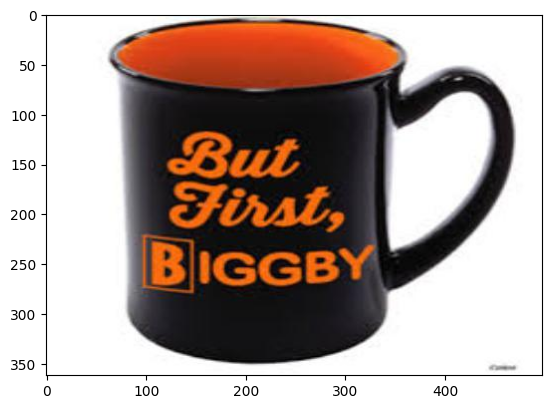

In [13]:
image_file_name = os.listdir(images_dir)[10]

example = os.path.join(images_dir, image_file_name)
img = Image.open(example)
plt.imshow(img)

In [14]:
# Function to parse XML and extract bounding box data
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    image_data = []

    # Get image filename and size (assuming standard PASCAL VOC structure)
    filename = os.path.basename(xml_file).replace('.xml', '.jpg')
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        x_min = int(bbox.find('xmin').text)
        y_min = int(bbox.find('ymin').text)
        x_max = int(bbox.find('xmax').text)
        y_max = int(bbox.find('ymax').text)

        image_data.append({
            'image_filename': filename,
            'logo_class': label,
            'x_min': x_min,
            'y_min': y_min,
            'x_max': x_max,
            'y_max': y_max
        })

    return image_data
# Load all annotations into a DataFrame
annotations = []
for xml_file in os.listdir(annotations_dir):
    if xml_file.endswith('.xml'):
        annotations.extend(parse_annotation(os.path.join(annotations_dir, xml_file)))

df = pd.DataFrame(annotations)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60656 entries, 0 to 60655
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filename  60656 non-null  object
 1   logo_class      60656 non-null  object
 2   x_min           60656 non-null  int64 
 3   y_min           60656 non-null  int64 
 4   x_max           60656 non-null  int64 
 5   y_max           60656 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.8+ MB


In [16]:
df.head(10)

,image_filename,logo_class,x_min,y_min,x_max,y_max
0,ClothesBirkenstock109.jpg,logo,33,147,448,202
1,FoodHotPockets49.jpg,logo,130,54,349,131
2,Clothesrobertallen8.jpg,logo,50,106,437,263
3,Foodmontesierpe46.jpg,logo,12,179,468,276
4,ClothesArcopedico76.jpg,logo,6,199,235,256
5,ClothesAdmiral161.jpg,logo,3,2,508,212
6,FoodCaribouCoffee93.jpg,logo,11,198,211,276
7,FoodGardettos21.jpg,logo,167,60,431,200
8,ClothesHeat27.jpg,logo,22,88,481,273
9,FoodBullsEyeBarbecue116.jpg,logo,27,131,111,263


In [17]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
df['logo_class_id'] = lb.fit_transform(df['logo_class'])

In [18]:
df.head(10)

,image_filename,logo_class,x_min,y_min,x_max,y_max,logo_class_id
0,ClothesBirkenstock109.jpg,logo,33,147,448,202,0
1,FoodHotPockets49.jpg,logo,130,54,349,131,0
2,Clothesrobertallen8.jpg,logo,50,106,437,263,0
3,Foodmontesierpe46.jpg,logo,12,179,468,276,0
4,ClothesArcopedico76.jpg,logo,6,199,235,256,0
5,ClothesAdmiral161.jpg,logo,3,2,508,212,0
6,FoodCaribouCoffee93.jpg,logo,11,198,211,276,0
7,FoodGardettos21.jpg,logo,167,60,431,200,0
8,ClothesHeat27.jpg,logo,22,88,481,273,0
9,FoodBullsEyeBarbecue116.jpg,logo,27,131,111,263,0


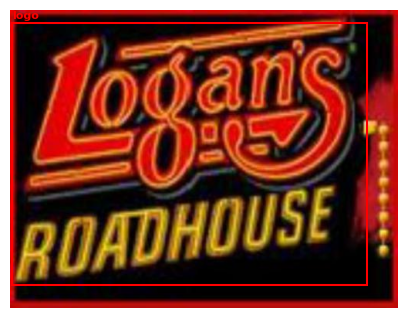

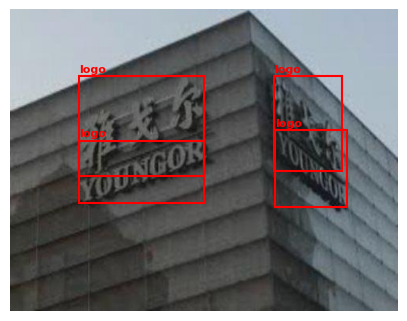

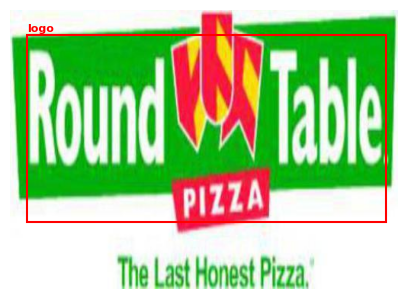

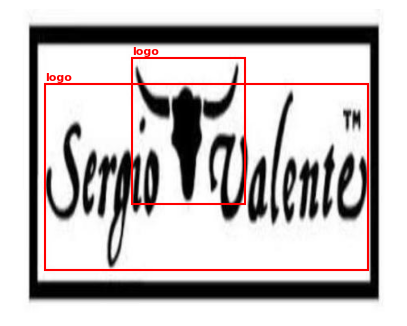

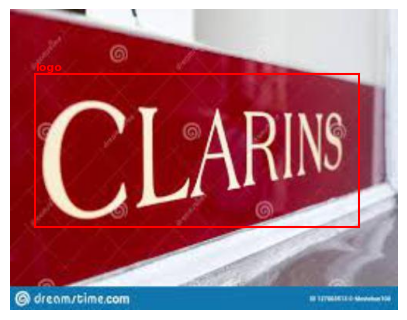

In [19]:
#Plot image with bboxs

def plot_sample_with_bboxes(df, n=5):
    sample_images = df['image_filename'].sample(n).unique()
    for img_name in sample_images:
        img_path = os.path.join(images_dir, img_name)
        img_df = df[df['image_filename'] == img_name]
        with Image.open(img_path) as img:
            plt.figure(figsize=(5, 5))
            plt.imshow(img)
            for _, row in img_df.iterrows():
                x_min, y_min, x_max, y_max = row['x_min'], row['y_min'], row['x_max'], row['y_max']
                plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                                  linewidth=1.5, edgecolor='red', facecolor='none'))
                plt.text(x_min, y_min - 5, row['logo_class'], color='red', fontsize=8, weight='bold')
            plt.axis('off')
            plt.show()

plot_sample_with_bboxes(df, n=5)

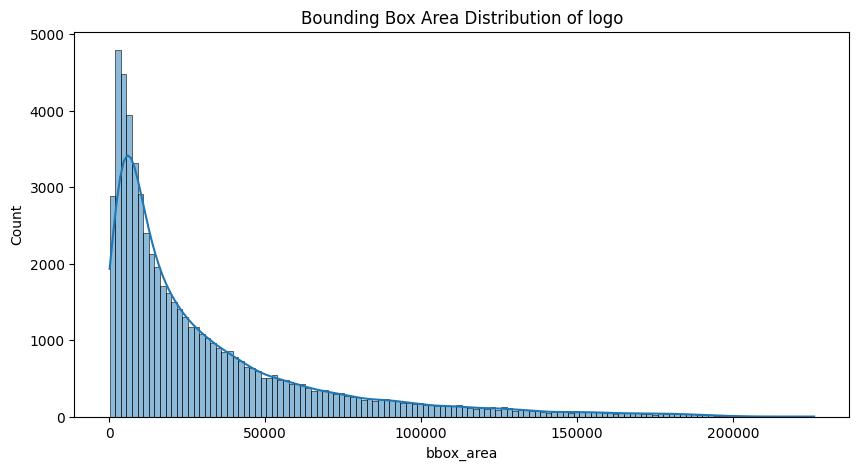

In [20]:
df['bbox_width'] = df['x_max'] - df['x_min']
df['bbox_height'] = df['y_max'] - df['y_min']
df['bbox_area'] = df['bbox_width'] * df['bbox_height']
plt.figure(figsize=(10, 5))
sns.histplot(df['bbox_area'], kde=True)
plt.title(f"Bounding Box Area Distribution of {df['logo_class'][0]}")
plt.show()

Logo Size Distribution:
logo_size
medium    30320
small     15172
large     15164
Name: count, dtype: int64


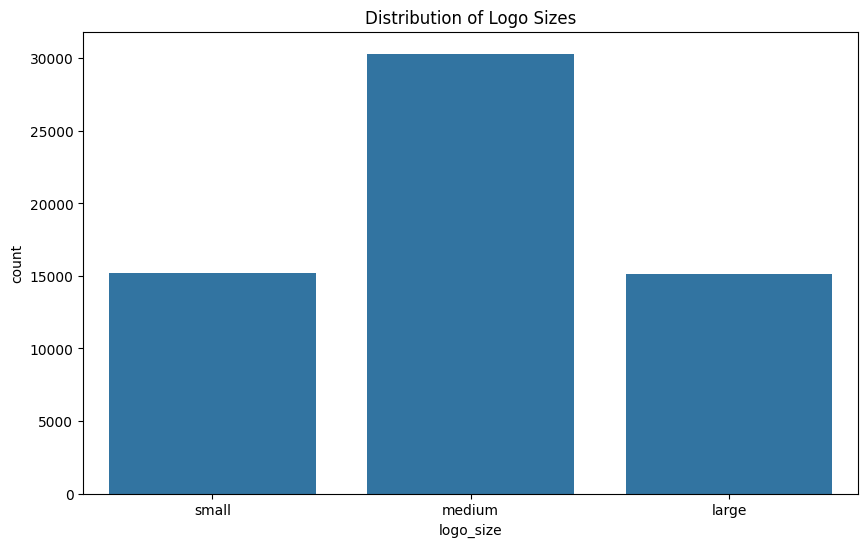

In [21]:
# Calculate the area thresholds for small, medium, and large logos
small_threshold = df['bbox_area'].quantile(0.25)
large_threshold = df['bbox_area'].quantile(0.75)

# Define a function to label each bounding box
def categorize_logo_size(area):
    if area <= small_threshold:
        return 'small'
    elif area <= large_threshold:
        return 'medium'
    else:
        return 'large'

# Apply the function to create a new column in the DataFrame
df['logo_size'] = df['bbox_area'].apply(categorize_logo_size)

# Display the count of each logo size category
print("Logo Size Distribution:")
print(df['logo_size'].value_counts())

# Visualize the distribution of logo sizes
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='logo_size', order=['small', 'medium', 'large'])
plt.title("Distribution of Logo Sizes")
plt.show()


# Yolo


##Load model

In [22]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 92.1MB/s]


> Resize to 640 square image for YOLO

In [23]:
from PIL import Image
from torchvision import transforms

# Define image transforms
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),  # Convert image to Tensor
])


# Load an image and apply the transform
image_file_name = os.listdir(images_dir)[10]
image_path = os.path.join(images_dir, image_file_name)

file_name_without_extension = os.path.splitext(os.path.basename(image_path))[0]
xml_path = os.path.join(annotations_dir, f"{file_name_without_extension}.xml")
image = Image.open(image_path)
image_transform = transform(image)
image_transform = image_transform.unsqueeze(0)  # Add batch dimension

In [24]:
def plot_bboxes(image_path, xml_path, predictions, confidence_threshold=0.25):
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Parse XML to get ground truth bounding boxes
    image_data = parse_annotation(xml_path)
    ground_truth_boxes = [[data['x_min'], data['y_min'], data['x_max'], data['y_max']] for data in image_data]

    # Set up the plot
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Plot ground truth bounding boxes (in green)
    for box in ground_truth_boxes:
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)

    # Plot predicted bounding boxes (in red) if confidence is above threshold
    for box, score in zip(predictions[0].boxes.xyxy, predictions[0].boxes.conf):
        if score > confidence_threshold:
            xmin, ymin, xmax, ymax = box.tolist()
            width = xmax - xmin
            height = ymax - ymin
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin - 5, f"{score:.2f}", color='red', fontsize=12)

    # Set title and show the plot
    plt.title("Blue: Ground Truth | Red: Predicted")
    plt.axis("off")
    plt.show()

In [25]:
with torch.no_grad():
    predictions = model.predict(image_transform)


0: 640x640 (no detections), 8.6ms
Speed: 1.3ms preprocess, 8.6ms inference, 124.1ms postprocess per image at shape (1, 3, 640, 640)


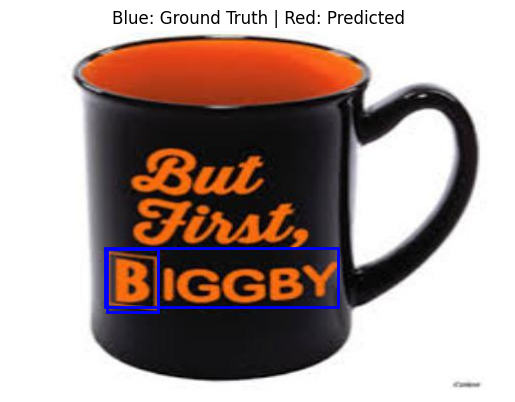

In [26]:
# Plot the bounding boxes
plot_bboxes(image_path, xml_path, predictions, confidence_threshold=0.5)

##Split and convert dataset annotation format to train YOLO

In [27]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
dataset_dir = "LogoData"
images_dir = os.path.join(dataset_dir, "images")
annotations_dir = os.path.join(dataset_dir, "logo_annotation")

# Output directories
output_dirs = {
    "train": {
        "images": os.path.join(dataset_dir, "train/images"),
        "labels": os.path.join(dataset_dir, "train/labels"),
    },
    "val": {
        "images": os.path.join(dataset_dir, "val/images"),
        "labels": os.path.join(dataset_dir, "val/labels"),
    },
    "test": {
        "images": os.path.join(dataset_dir, "test/images"),
        "labels": os.path.join(dataset_dir, "test/labels"),
    },
}

# Create output directories
for split, paths in output_dirs.items():
    for path in paths.values():
        os.makedirs(path, exist_ok=True)

# Get list of image and annotation files
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith((".jpg", ".png", ".jpeg"))])
annotation_files = sorted([f for f in os.listdir(annotations_dir) if f.endswith(".xml")])

# Ensure images and labels match
image_stems = [os.path.splitext(f)[0] for f in image_files]
annotation_stems = [os.path.splitext(f)[0] for f in annotation_files]
assert image_stems == annotation_stems, "Mismatch between images and labels"

# Split into train, val, test (7:2:1 ratio)
train_images, temp_images, train_labels, temp_labels = train_test_split(
    image_files, annotation_files, test_size=0.3, random_state=123
)
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.333, random_state=123
)  # 0.333 of 0.3 = 0.1

# Helper function to move files
def move_files(file_list, source_dir, dest_dir):
    for file in file_list:
        shutil.move(os.path.join(source_dir, file), os.path.join(dest_dir, file))

# Move files to respective directories
move_files(train_images, images_dir, output_dirs["train"]["images"])
move_files(val_images, images_dir, output_dirs["val"]["images"])
move_files(test_images, images_dir, output_dirs["test"]["images"])

move_files(train_labels, annotations_dir, output_dirs["train"]["labels"])
move_files(val_labels, annotations_dir, output_dirs["val"]["labels"])
move_files(test_labels, annotations_dir, output_dirs["test"]["labels"])

print("Dataset successfully split into train, val, and test sets!")

Dataset successfully split into train, val, and test sets!


In [28]:
images = os.listdir('/content/LogoData/train/images')
classes = ['Necessities', 'Clothes', 'Food']
images_class = []
for f in images:
  for cls in classes:
    if cls in f:
      images_class.append(cls)

pd.Series(images_class).value_counts()

,count
Food,16965
Clothes,10100
Necessities,7948


In [29]:
import os
import xml.etree.ElementTree as ET
from pathlib import Path
from PIL import Image

def convert_voc_to_yolo(dataset_dir, class_names=sorted(df['logo_class'].unique())):
    """Convert Pascal VOC annotations to YOLO format."""
    dataset_dir = Path(dataset_dir)
    annotations_path = os.path.join(dataset_dir, 'labels')
    annotations_dir = Path(annotations_path)
    images_dir = os.path.join(dataset_dir, 'images')

    # Go through each xml file in the dataset directory
    for xml_file in annotations_dir.glob('*.xml'):
        # Parse the XML file
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Get image filename
        image_name = xml_file.stem + '.jpg'
        image_path = os.path.join(images_dir, image_name)

        # If image doesn't exist, skip this annotation
        if not os.path.exists(image_path):
            print(f"Warning: Image {image_name} not found for annotation {xml_file}")
            continue

        # Get image dimensions
        image = Image.open(image_path)
        width, height = image.size

        # Create the output .txt file (same name as .xml)
        txt_file = os.path.join(annotations_path, (xml_file.stem + '.txt'))

        with open(txt_file, 'w') as f:
            # Loop through each object in the annotation
            for obj in root.findall('object'):
                #class_name = obj.find('name').text
                #class_id = class_names.index(class_name)

                # Get bounding box coordinates
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)

                # Convert bounding box to YOLO format (normalized)
                x_center = (xmin + xmax) / 2.0 / width
                y_center = (ymin + ymax) / 2.0 / height
                obj_width = (xmax - xmin) / float(width)
                obj_height = (ymax - ymin) / float(height)

                # Write the annotation for the object in YOLO format
                f.write(f"0 {x_center} {y_center} {obj_width} {obj_height}\n")
                #print(f"{class_name} - {class_id} {x_center} {y_center} {obj_width} {obj_height}")

        os.remove(xml_file)

    print("Conversion complete.")

# Usage Example:
train_dir = '/content/LogoData/train'
test_dir = '/content/LogoData/test'
val_dir = '/content/LogoData/val'
convert_voc_to_yolo(train_dir)
convert_voc_to_yolo(test_dir)
convert_voc_to_yolo(val_dir)

Conversion complete.
Conversion complete.
Conversion complete.


In [30]:
yaml_content = f"""
train: /content/LogoData/train/images
val: /content/LogoData/val/images
test: /content/LogoData/test/images

nc: 1

names: ["logo"]
"""

with open('/content/LogoData/logo_dataset.yaml', 'w') as f:
    f.write(yaml_content)

print("Dataset YAML created.")

Dataset YAML created.


In [31]:
!rm /content/LogoData/train/labels.cache
!rm /content/LogoData/val/labels.cache
!rm /content/LogoData/test/labels.cache

rm: cannot remove '/content/LogoData/train/labels.cache': No such file or directory
rm: cannot remove '/content/LogoData/val/labels.cache': No such file or directory
rm: cannot remove '/content/LogoData/test/labels.cache': No such file or directory


##Train Model
> Current best: optimizer=AdamW lr0=0.002 momentum=0.9 lrf=0.0001

In [32]:
!yolo train model=yolov8n.pt data=/content/LogoData/logo_dataset.yaml mode=train epochs=15 batch=16 workers=16  imgsz=416 half plots=True

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/LogoData/logo_dataset.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=16, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=True, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

## Evaluate model

In [33]:
!yolo predict model=/content/runs/detect/train/weights/best.pt source=/content/LogoData/test/images plots=True

Streaming output truncated to the last 5000 lines.
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

image 1/4995 /content/LogoData/test/images/Clothes2xist12.jpg: 320x416 1 logo, 57.0ms
image 2/4995 /content/LogoData/test/images/Clothes2xist62.jpg: 416x320 1 logo, 36.0ms
image 3/4995 /content/LogoData/test/images/Clothes2xist70.jpg: 320x416 (no detections), 7.2ms
image 4/4995 /content/LogoData/test/images/Clothes3DGOLD3.jpg: 320x416 1 logo, 6.2ms
image 5/4995 /content/LogoData/test/images/Clothes3DGOLD45.jpg: 320x416 1 logo, 6.3ms
image 6/4995 /content/LogoData/test/images/Clothes3DGOLD50.jpg: 352x416 1 logo, 35.5ms
image 7/4995 /content/LogoData/test/images/Clothes3DGOLD52.jpg: 320x416 (no detections), 7.3ms
image 8/4995 /content/LogoData/test/images/Clothes3DGOLD53.jpg: 352x416 2 logos, 7.5ms
image 9/4995 /content/LogoData/test/images/Clothes4Skins28.jpg: 320x416 1 logo, 6.8ms
image 10/4995 /content/LogoData/test/images/Clothes4Skins4.jpg: 352x416 1 l

## Results
> See folder `runs/train/exp` for more details

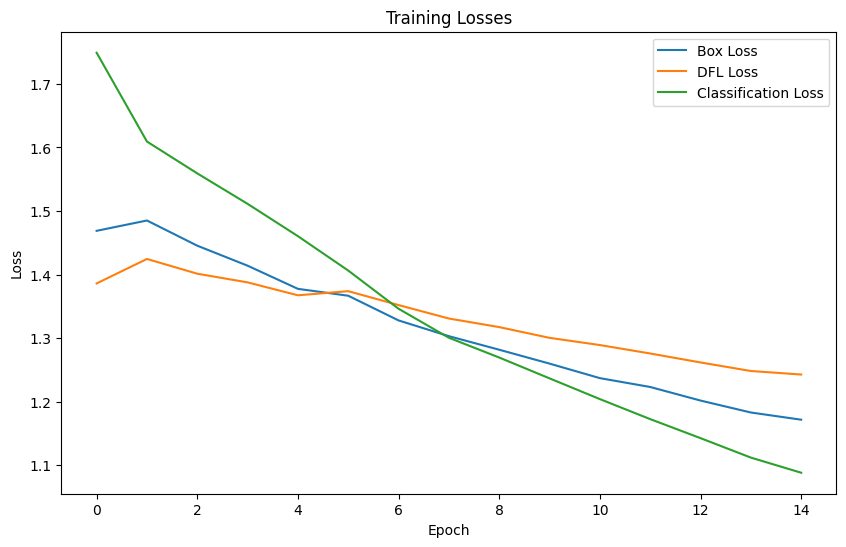

In [34]:
import yaml
import matplotlib.pyplot as plt

# Load the results.yaml file
results = pd.read_csv('/content/runs/detect/train/results.csv')

epochs = np.arange(0, len(results['epoch']))  # Number of epochs
train_box_loss = results['train/box_loss']
train_cls_loss = results['train/cls_loss']
train_dfl_loss = results['train/dfl_loss']

val_box_loss = results['val/box_loss']
val_cls_loss = results['val/cls_loss']
val_dfl_loss = results['val/dfl_loss']

precision = results['metrics/precision(B)']
recall = results['metrics/recall(B)']
map = results['metrics/mAP50(B)']
map95 = results['metrics/mAP50-95(B)']



plt.figure(figsize=(10, 6))
plt.plot(epochs, train_box_loss, label='Box Loss')
plt.plot(epochs, train_dfl_loss, label='DFL Loss')
plt.plot(epochs, train_cls_loss, label='Classification Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

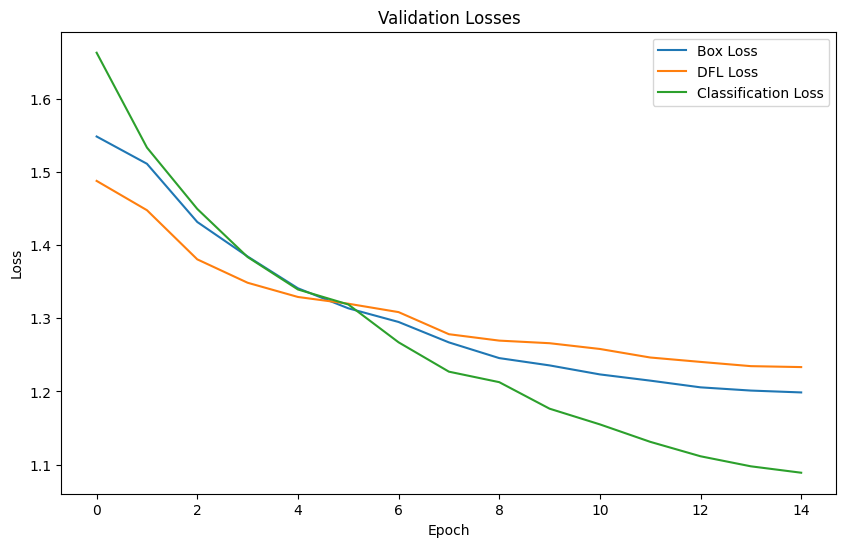

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_box_loss, label='Box Loss')
plt.plot(epochs, val_dfl_loss, label='DFL Loss')
plt.plot(epochs, val_cls_loss, label='Classification Loss')
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

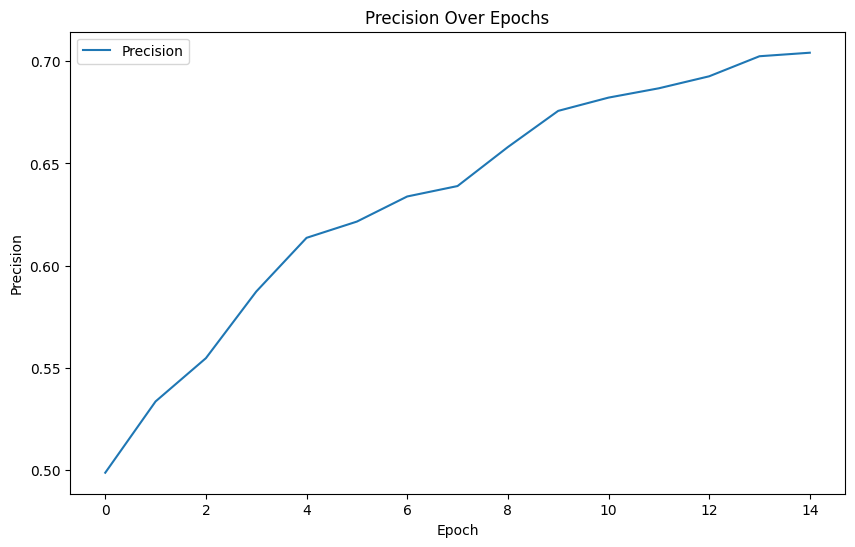

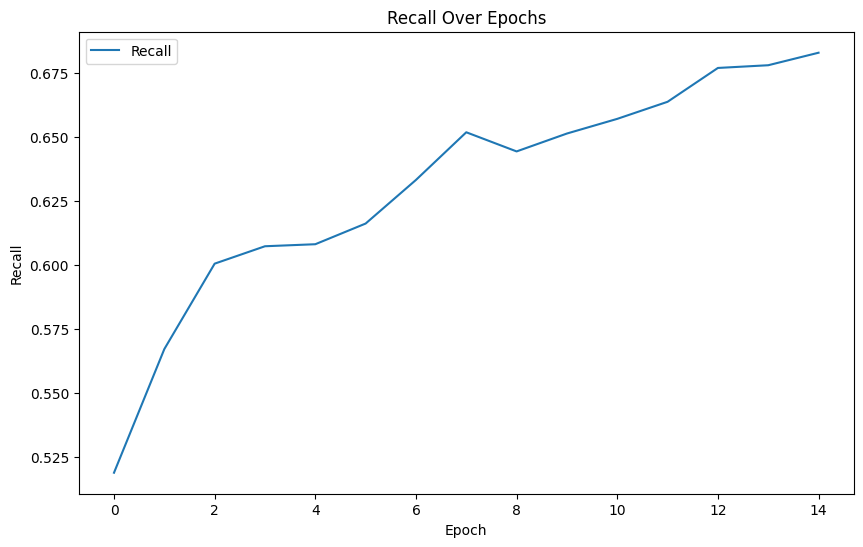

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, precision, label='Precision')
plt.title('Precision Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot Recall
plt.figure(figsize=(10, 6))
plt.plot(epochs, recall, label='Recall')
plt.title('Recall Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

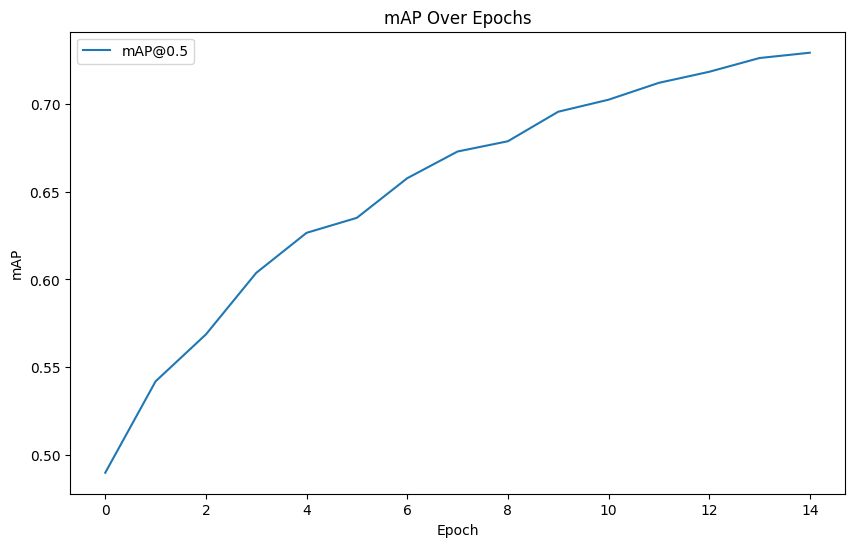

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, map, label='mAP@0.5')
plt.title('mAP Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()
plt.show()


# Download runs folder as zip

In [38]:
!zip -r /content/runs.zip /content/runs

Streaming output truncated to the last 5000 lines.
  adding: content/runs/detect/train/labels_correlogram.jpg (deflated 25%)
  adding: content/runs/detect/train/P_curve.png (deflated 18%)
  adding: content/runs/detect/train/train_batch10940.jpg (deflated 18%)
  adding: content/runs/detect/train/results.csv (deflated 58%)
  adding: content/runs/detect/predict/ (stored 0%)
  adding: content/runs/detect/predict/Foodtimothysworldcoffee35.jpg (deflated 4%)
  adding: content/runs/detect/predict/FoodBullyBoyDistillers16.jpg (deflated 12%)
  adding: content/runs/detect/predict/FoodCarnation64.jpg (deflated 8%)
  adding: content/runs/detect/predict/Clothesgaranimals37.jpg (deflated 8%)
  adding: content/runs/detect/predict/Foodcookiecrisp44.jpg (deflated 20%)
  adding: content/runs/detect/predict/FoodCaptainMorgan75.jpg (deflated 6%)
  adding: content/runs/detect/predict/Necessitiesmarkorfurnishings40.jpg (deflated 8%)
  adding: content/runs/detect/predict/Clothessuperfeet55.jpg (deflated 16%)


#Demo some post-training predict result

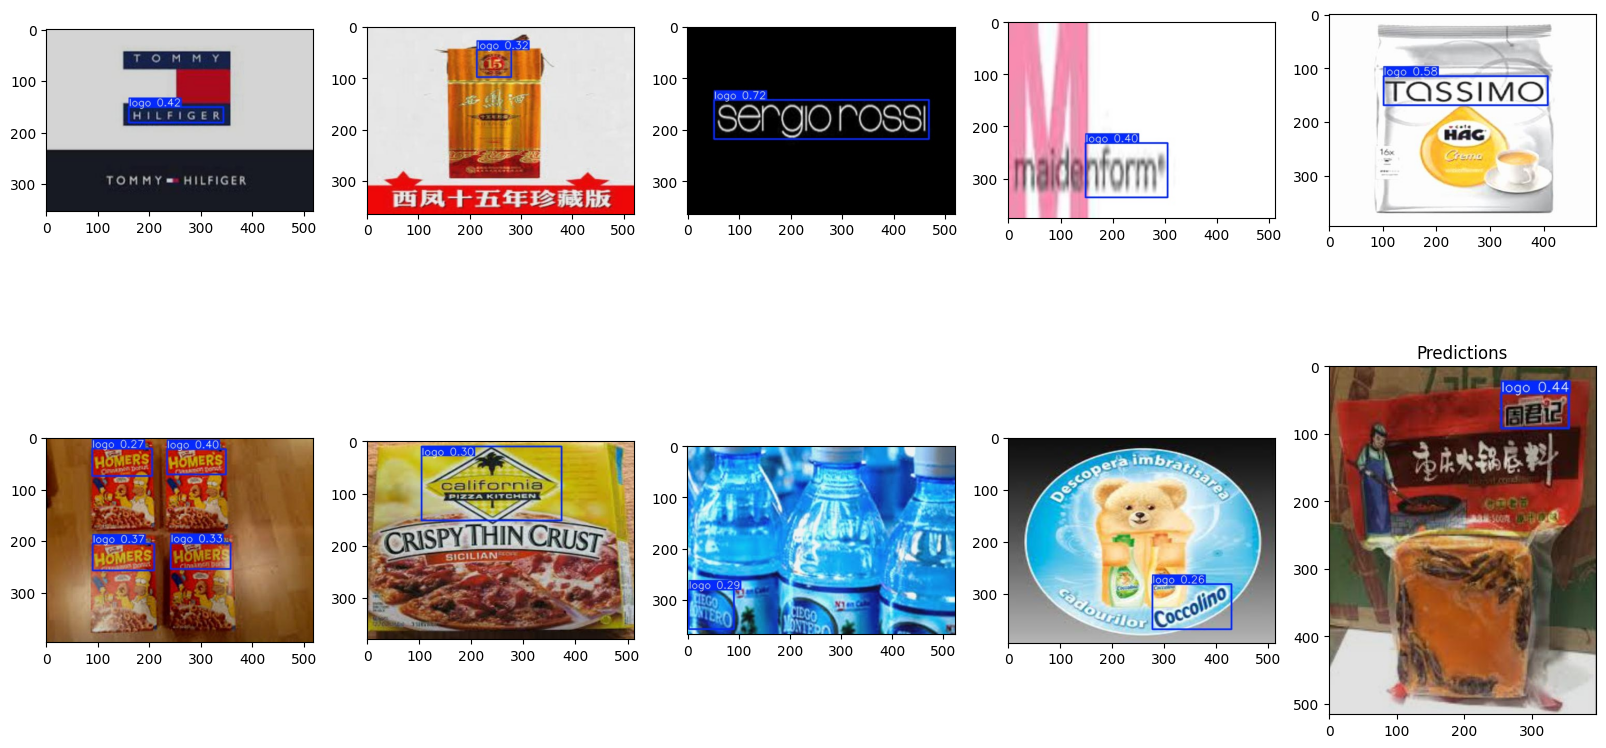

In [39]:
import matplotlib.image as mlimage

n_samples = 10

predict_dir = '/content/runs/detect/predict'
all_images =  os.listdir(predict_dir)
sample_indexes = np.random.randint(0, len(all_images), n_samples)

image_paths = np.array(all_images)[sample_indexes]

fig, ax = plt.subplots(int(n_samples / 5), 5, figsize=(20, 10))

img_idx = 0
for i in range (int(n_samples / 5)):
  for j in range(5):
    image = mlimage.imread(os.path.join(predict_dir, image_paths[img_idx]))
    ax[i][j].imshow(image)
    img_idx += 1

plt.title("Predictions")
plt.show()